In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from p_tqdm import p_map
import os, sys
from functools import reduce

In [2]:
sector='AMEL_clipped'
pulse_year=2020
rff_path=f"/mnt/CIL_integration/rff3_with_disc_factors/iter0-19/{sector}/{pulse_year}/unmasked_None/"
ssp_path=f"/mnt/CIL_integration/menu_results_AR6_bc39_epa_vsl_continuous/{sector}/{pulse_year}/unmasked"
out_path="/mnt/CIL_integration/rff_diagnostics/discount_factors"
recipe='risk_aversion'
quantiles = [
    (0,1), 
    (0.005, 0.995),
    (0.01, 0.99),
    (0.05, 0.95)
]
eta=2.0
rho=0.0
disc='euler_ramsey'
title=None

In [3]:
# rff plots
rff_factors = xr.open_zarr(f"{rff_path}/{recipe}_{disc}_eta{eta}_rho{rho}_uncollapsed_discount_factors.zarr").chunk({'simulation' : -1})
rff_factors["rate"] = (1 / rff_factors.discount_factor) ** (
    1 / (rff_factors.year - pulse_year)
) - 1

# quantiles
quants = []
for q in quantiles:
    df = rff_factors.quantile([q[0], q[1]], ['rff_sp', 'simulation']).to_dataframe().reset_index().sort_values('weitzman_parameter')
    quants.append(df)
data = pd.concat(quants).reset_index()

# mean and median
median = rff_factors.quantile(0.5, ['rff_sp', 'simulation']).to_dataframe().sort_values('weitzman_parameter').reset_index()
mean = rff_factors.mean(['rff_sp', 'simulation']).to_dataframe().sort_values('weitzman_parameter').reset_index()
median['scenario'] = 'RFF median'
mean['scenario'] = 'RFF mean'

In [4]:
# ssp plots

ssp_factors = xr.open_dataset(f"{ssp_path}/{recipe}_{disc}_eta{eta}_rho{rho}_discount_factors.nc4").sel(fair_aggregation='ce')
ssp_factors["rate"] = (1 / ssp_factors.discount_factors) ** (
    1 / (ssp_factors.year - pulse_year)
) - 1
ssp_factors = ssp_factors.to_dataframe().reset_index()
ssp_factors['scenario'] = reduce(lambda a,b: a + '-' + b,
                                      [ssp_factors[i] for i in ['ssp', 'model', 'rcp']]
)

scenarios = ssp_factors.append(median).append(mean)

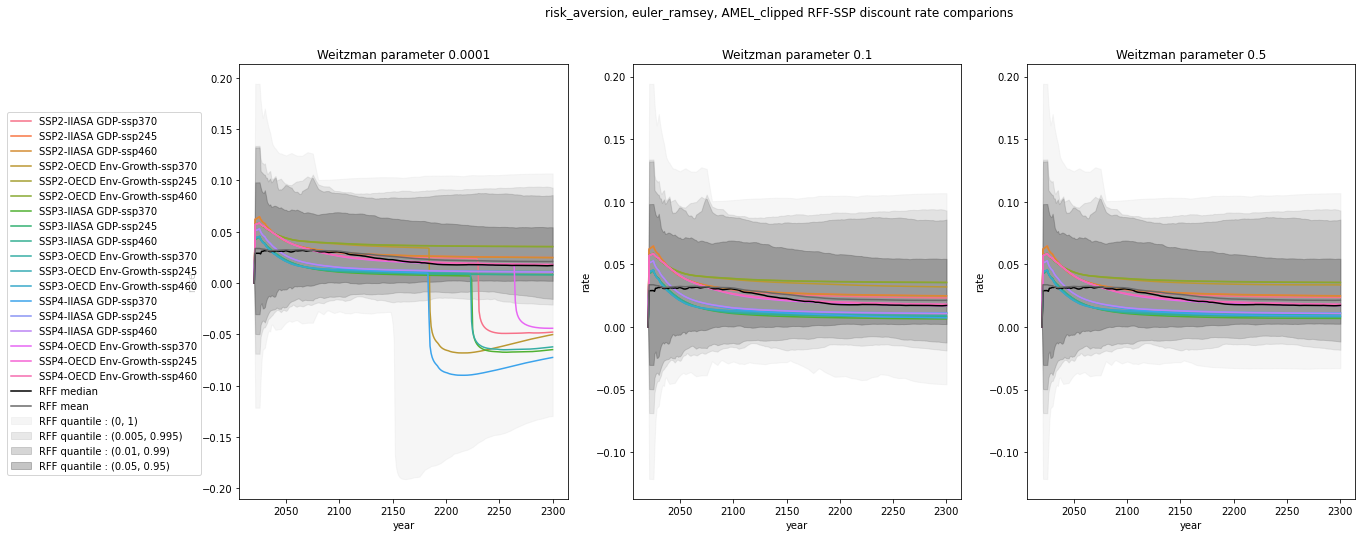

In [5]:
fig, ax = plt.subplots(1,3, figsize=(20,8))

for i, wp in enumerate(['0.0001', '0.1', '0.5']):
    
    ax[i].set_title(f"Weitzman parameter {wp}")
    
    subset = data.loc[data.weitzman_parameter == wp].sort_values('year')

    # ssp scenarios
    palette = sns.color_palette("husl", len(scenarios.scenario.unique())-2) + ['black', 'dimgrey']
    sns.lineplot(data=scenarios.loc[scenarios.weitzman_parameter == wp].reset_index(),
                 x='year',
                 y='rate',
                 ax=ax[i],
                 hue='scenario',
                 palette=palette
                )
    
    for col, q in enumerate(quantiles):
    
        # ribbon plots
        ax[i].fill_between(x=subset.loc[subset['quantile'] == q[0]].year, 
                         y1=subset.loc[subset['quantile'] == q[0]].rate, 
                         y2=subset.loc[subset['quantile'] == q[1]].rate,
                         color=sns.color_palette("Greys", len(quantiles))[col], 
                         alpha=0.3,
                         label=f"RFF quantile : {q}",
                        )
        
    if i > 0:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(bbox_to_anchor=(-0.1,0.90))
        
fig.suptitle(f"{recipe}, {disc}, {sector} RFF-SSP discount rate comparions")

plt.savefig(f"{out_path}/stacked_{recipe}_{disc}_{sector}_discount_rates.png", dpi=300, bbox_inches='tight')